In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [4]:
df_train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',
                       sep=',',
                       names=['tweet_id','entity','sentiment','tweet_content'])
df_val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',
                        sep=',',
                        names=['tweet_id','entity','sentiment','tweet_content'])

df_train.shape, df_val.shape

((74682, 4), (1000, 4))

In [5]:
df_train.head()

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df_train[(df_train['tweet_content'].str.contains(pat='(RT)\s')) & (~df_train['tweet_content'].isna())]

,tweet_id,entity,sentiment,tweet_content
379,2464,Borderlands,Neutral,I haven't done anything other than play Border...
2766,1681,CallOfDutyBlackopsColdWar,Negative,I’m RT this again just to let y’all know y’all...
2767,1681,CallOfDutyBlackopsColdWar,Negative,I'm back RT just to let y'all know that y'all ...
2768,1681,CallOfDutyBlackopsColdWar,Negative,I'm RT this again just to let y'all know y'all...
2769,1681,CallOfDutyBlackopsColdWar,Negative,I’m RT this again just to let god know that ne...
...,...,...,...,...
74269,9127,Nvidia,Positive,RT @ NVIDIACreators: Bring it to the MAX.. thi...
74270,9127,Nvidia,Positive,RT @ NVIDIACreators: This year on
74271,9127,Nvidia,Positive,RT @NVIDIACreators: Take it to the pub.. This...
74272,9127,Nvidia,Positive,RT @NVIDIACreators : Please Take it to the Par...


In [7]:
df_train.isna().sum()

tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [8]:
df_train['sentiment'].value_counts(normalize=True)

Negative      0.301840
Positive      0.278943
Neutral       0.245280
Irrelevant    0.173937
Name: sentiment, dtype: float64

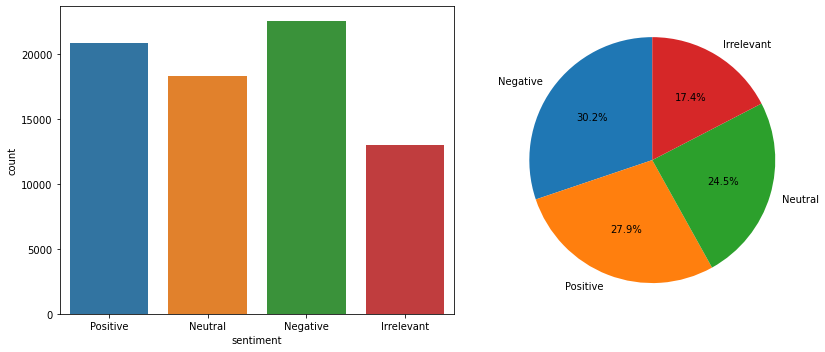

In [9]:


fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.countplot(df_train['sentiment'],ax=ax[0])
ax[1] = plt.pie(df_train['sentiment'].value_counts(normalize=True),
       labels=['Negative','Positive','Neutral','Irrelevant'],
       autopct='%1.1f%%',
       startangle=90)

fig.tight_layout()


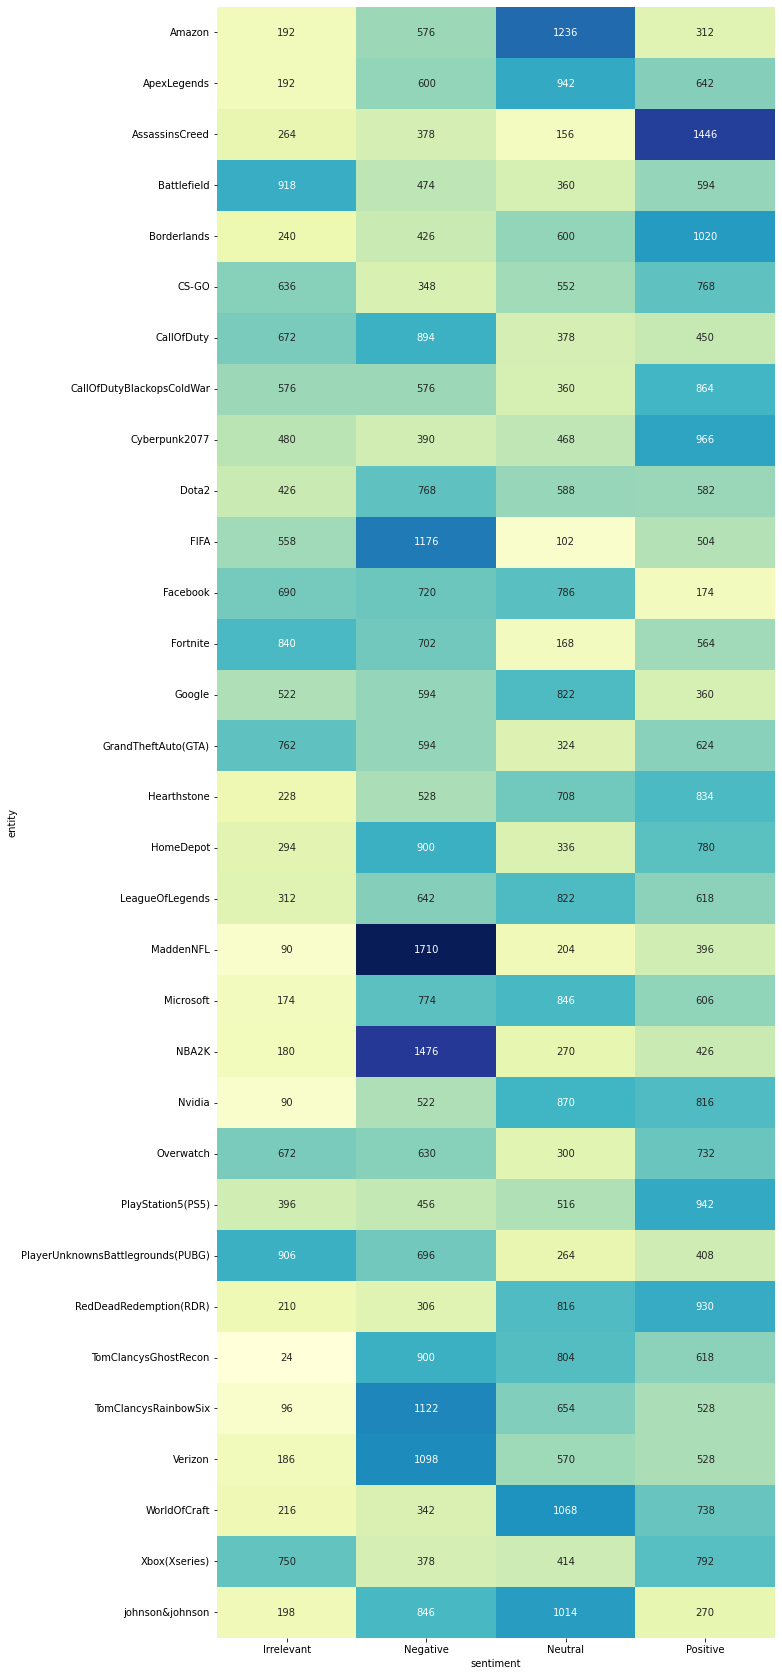

In [10]:
plt.figure(figsize=(10,30))
sns.heatmap(df_train.groupby(['entity', 'sentiment']).sentiment.count().unstack(),
            cmap="YlGnBu", annot=True, cbar=False,fmt='d')
plt.show()

In [11]:
print('The training data has %s tweets missing' % df_train.isna().sum()[-1])
print('The validation data has %s tweets missing' % df_val.isna().sum()[-1])

The training data has 686 tweets missing
The validation data has 0 tweets missing


In [12]:
df_train.dropna(axis=0, inplace=True)

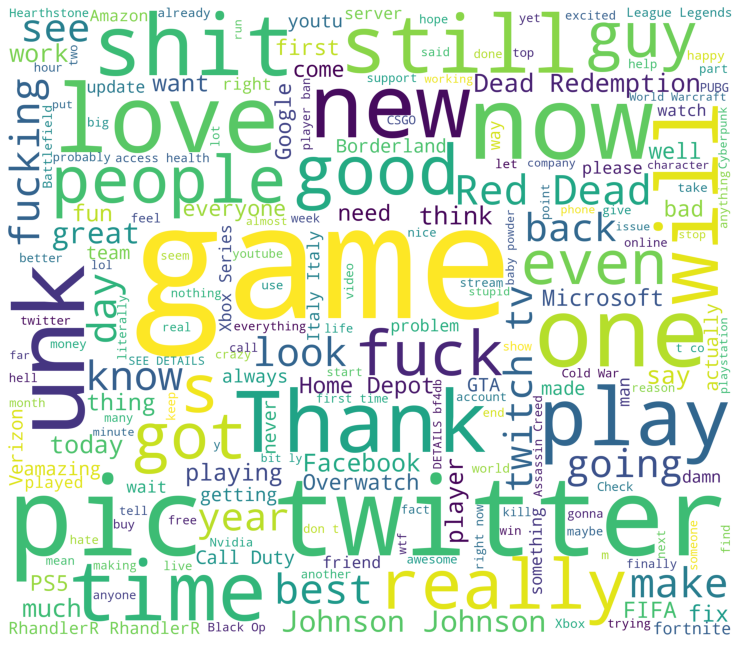

In [13]:
def draw_word_cloud(df, color='black'):
    words = ' '.join(df)
    words_cleaned = ' '.join([word for word in words.split() if not word.startswith(('#','@'))
                                 and 'http' not in word 
                                 and word != 'RT'
                                 and len(word)>=3])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2300,
                      height=2000
                     ).generate(words_cleaned)
    
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

draw_word_cloud(df_train['tweet_content'], 'white')

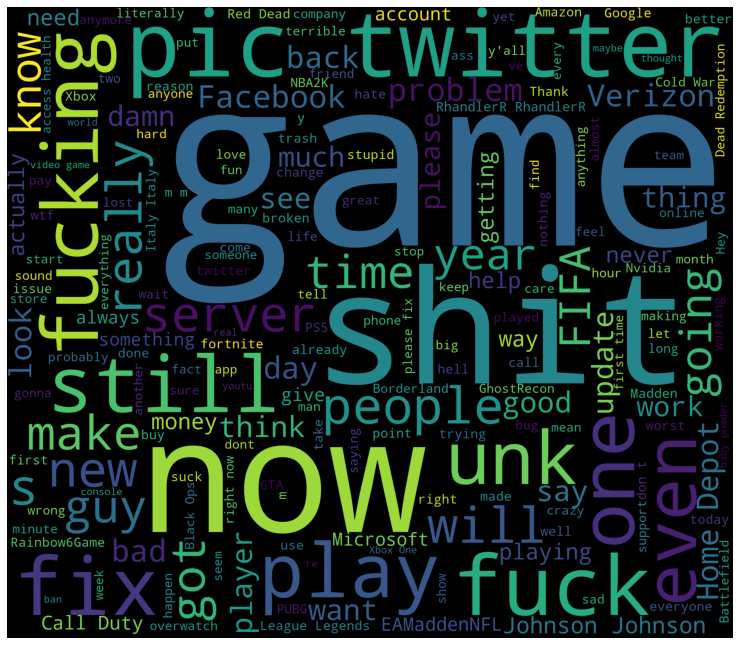

In [14]:
draw_word_cloud(df_train[df_train['sentiment'] == 'Negative']['tweet_content'], 'black')

In [15]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

sw = stopwords.words('english')

REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "

def stem_word(corpora):
    stem = PorterStemmer()
    return [' '.join([stem.stem(word) for word in corps.split()]) for corps in corpora]

def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    return reviews

def remove_stop_words(corpora):
    removed_stop_words = [' '.join(word for word in corpus.split() if word not in sw) 
                          for corpus in corpora]
    return removed_stop_words

In [16]:
tweet_train  = df_train["tweet_content"]
# tweet_v =v_df["Tweet_content"]
target =df_train['sentiment']

#1
review_train = reviews(tweet_train)
# reviewv = reviews(tweet_v)
#2
no_stop_words_train = remove_stop_words(review_train)
# no_stop_words_v = remove_stop_words(reviewv)
#3
stemmed_reviews_train = stem_word(no_stop_words_train)
# stemmed_reviews_test = get_stemmed_text(no_stop_words_v)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(stemmed_reviews_train)

# X = tfidf_vectorizer.transform(stemmed_reviews_train)
X_test = tfidf_vectorizer.transform(df_val['tweet_content'])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.8)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

text_classifier = RandomForestClassifier(n_estimators=50, random_state=0)
text_classifier.fit(X_train, y_train)



RandomForestClassifier(n_estimators=50, random_state=0)

In [23]:
y_pred=text_classifier.predict(X_val)

print(classification_report(y_val,y_pred))


              precision    recall  f1-score   support

  Irrelevant       0.98      0.85      0.91      2613
    Negative       0.92      0.94      0.93      4422
     Neutral       0.93      0.89      0.91      3598
    Positive       0.87      0.94      0.90      4167

    accuracy                           0.91     14800
   macro avg       0.92      0.91      0.91     14800
weighted avg       0.92      0.91      0.91     14800



In [33]:
y_test = np.array(df_val['sentiment'].tolist())

In [35]:
y_pred_test=text_classifier.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

  Irrelevant       0.91      0.56      0.69       172
    Negative       0.79      0.85      0.82       266
     Neutral       0.69      0.88      0.77       285
    Positive       0.81      0.70      0.75       277

    accuracy                           0.77      1000
   macro avg       0.80      0.75      0.76      1000
weighted avg       0.78      0.77      0.76      1000



In [36]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred_mnb=text_classifier.predict(X_val)

print(classification_report(y_val,y_pred_mnb))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.85      0.91      2613
    Negative       0.92      0.94      0.93      4422
     Neutral       0.93      0.89      0.91      3598
    Positive       0.87      0.94      0.90      4167

    accuracy                           0.91     14800
   macro avg       0.92      0.91      0.91     14800
weighted avg       0.92      0.91      0.91     14800



In [37]:
y_pred_test_mnb=mnb.predict(X_test)
print(classification_report(y_test, y_pred_test_mnb))

              precision    recall  f1-score   support

  Irrelevant       0.94      0.39      0.55       172
    Negative       0.68      0.79      0.73       266
     Neutral       0.77      0.70      0.73       285
    Positive       0.64      0.84      0.73       277

    accuracy                           0.71      1000
   macro avg       0.76      0.68      0.69      1000
weighted avg       0.74      0.71      0.70      1000

